In [3]:
import tensorflow as tf
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow_datasets as tfds

In [1]:
!pip install tensorflow_datasets

In [4]:
mnist_train_data, info = tfds.load('fashion_mnist', split='train', with_info=True)
mnist_test_data = tfds.load('fashion_mnist', split='test')

In [5]:
mnist_test_data

<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
p = list(mnist_test_data)

Bag


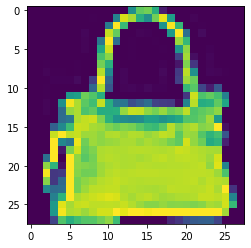

In [8]:
ix = random.randint(0, len(p)-1)
plt.imshow(np.reshape(p[ix]['image'], (28, 28)))
print(class_names[p[ix]['label'].numpy()])

In [9]:
def format_image(data):
    image = data['image']
    image = tf.reshape(image, [-1]) ## reshaping to 784
    image = tf.cast(image, 'float32')
    image = image/255.0
    return image, data['label']

In [10]:
train_preprocessed_data = mnist_train_data.map(format_image)
test_preprocessed_data = mnist_test_data.map(format_image)

In [11]:
batch_size = 64
train_data = train_preprocessed_data.shuffle(buffer_size=1024).batch(batch_size)
test_data = test_preprocessed_data.batch(batch_size)

In [12]:
train_metrics = tf.keras.metrics.SparseCategoricalAccuracy()
val_metrics = tf.keras.metrics.SparseCategoricalAccuracy()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()


In [13]:
optimizer = tf.keras.optimizers.Adam()

In [14]:
def baseline_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(784,), name='digits'),
        tf.keras.layers.Dense(32, activation='relu', name='dense1'),
        tf.keras.layers.Dense(64, activation='relu', name='dense2'),
        tf.keras.layers.Dense(64, activation='relu', name='dense3'),
        tf.keras.layers.Dense(10, activation='softmax', name='output')
    ])
    return model

In [15]:
model = baseline_model()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 32)                25120     
_________________________________________________________________
dense2 (Dense)               (None, 64)                2112      
_________________________________________________________________
dense3 (Dense)               (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 32,042
Trainable params: 32,042
Non-trainable params: 0
_________________________________________________________________


In [17]:
def apply_gradients(model, inputs, outputs):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss = loss_object(y_true=outputs, y_pred=logits)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return logits, loss

In [18]:
def train_on_epoch():
    losses = []
    for step, (x_train, y_train) in enumerate(train_data):
        logits, loss = apply_gradients(model, x_train, y_train)
        losses.append(loss)
#         print(logits.dtype, y_train.dtype, 'train data')
        train_metrics(y_train, logits)
    return losses
        

In [19]:
def validation_on_epoch():
    losses = []
    for step, (x_train, y_train) in enumerate(test_data):
#         print(x_train)
#         print(y_train)
        logits = model(x_train)
#         print(logits.dtype, y_train.dtype, 'validation')
        loss = loss_object(y_true=y_train, y_pred=logits)
        losses.append(loss)
        val_metrics(y_train, logits)
    return losses


In [20]:
train_losses = []
test_losses = []
for _ in range(10):
    train_loss = train_on_epoch()
    test_loss = validation_on_epoch()
    train_losses.append(np.mean(train_loss))
    test_losses.append(np.mean(test_loss))
    print('Epoch number ', _, ' train loss = ', train_losses[-1], ' train acc = ', train_metrics.result().numpy(), 
          'val loss = ', test_losses[-1], ' val acc = ', val_metrics.result().numpy())
    val_metrics.reset_states()
    train_metrics.reset_states()
    

Epoch number  0  train loss =  0.55896986  train acc =  0.80256665 val loss =  0.44294286  val acc =  0.8463
Epoch number  1  train loss =  0.4001809  train acc =  0.85606664 val loss =  0.40806466  val acc =  0.855
Epoch number  2  train loss =  0.3623969  train acc =  0.86651665 val loss =  0.42830265  val acc =  0.8479
Epoch number  3  train loss =  0.34032807  train acc =  0.8746667 val loss =  0.39608058  val acc =  0.8605
Epoch number  4  train loss =  0.32484016  train acc =  0.8793 val loss =  0.37259996  val acc =  0.8675
Epoch number  5  train loss =  0.3121917  train acc =  0.8844 val loss =  0.3696447  val acc =  0.8691
Epoch number  6  train loss =  0.29995275  train acc =  0.8875833 val loss =  0.3904512  val acc =  0.8602
Epoch number  7  train loss =  0.291381  train acc =  0.89038336 val loss =  0.34977818  val acc =  0.877
Epoch number  8  train loss =  0.28140485  train acc =  0.8948 val loss =  0.37446716  val acc =  0.8716
Epoch number  9  train loss =  0.27697578 

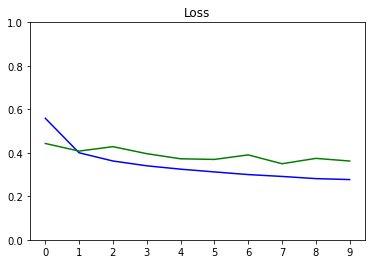

In [21]:
import matplotlib.ticker as mticker

def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(train_losses, test_losses, "Loss", "Loss", ylim=1.0)


In [22]:
def display_images(image, predictions, labels, title, n):

    display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], display_strings)
    plt.grid(None)
    image = np.reshape(image, [n, 28, 28])
    image = np.swapaxes(image, 0, 1)
    image = np.reshape(image, [28, 28*n])
    plt.imshow(image)


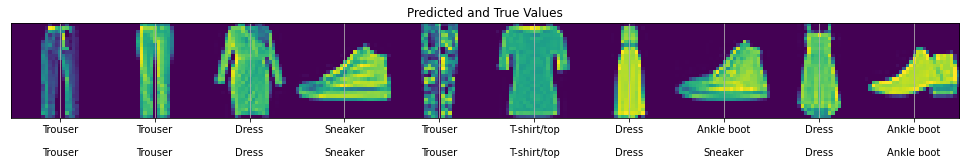

In [24]:
test_inputs = test_preprocessed_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in (test_inputs):
    y_pred = model(x)
    y_pred_batches = y_pred.numpy()
    y_true_batches = y.numpy()
    x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)